In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Super resolution data

In [2]:
from fastai.conv_learner import *
from pathlib import Path
torch.cuda.set_device(0)

torch.backends.cudnn.benchmark=True

In [3]:
PATH = Path('data/imgnet-samp/')
PATH_TRN = PATH/'train'

In [4]:
fnames,label_arr,all_labels = folder_source(PATH, 'train')
fnames = ['/'.join(Path(fn).parts[-2:]) for fn in fnames]
list(zip(fnames[:5],label_arr[:5]))

[('n01440764/n01440764_8938.JPEG', 0),
 ('n01440764/n01440764_63.JPEG', 0),
 ('n01440764/n01440764_11787.JPEG', 0),
 ('n01440764/n01440764_8063.JPEG', 0),
 ('n01440764/n01440764_6878.JPEG', 0)]

In [5]:
all_labels[:5]

['n01440764', 'n01443537', 'n01491361', 'n01494475', 'n01498041']

In [6]:
arch = resnet34
sz_hr,sz_lr = 288,72
bs = 16

In [7]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [8]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.PIXEL),
            RandomFlip(tfm_y=TfmType.PIXEL),
            RandomLighting(0.05, 0.05)]
# aug_tfms = []

In [9]:
val_idxs = get_cv_idxs(len(fnames), val_pct=0.1)
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames), np.array(fnames))
len(val_x),len(trn_x)

(1943, 17496)

In [10]:
tfms = tfms_from_model(arch, sz_lr, tfm_y=TfmType.PIXEL, aug_tfms=aug_tfms, sz_y=sz_hr)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH_TRN)
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)

In [11]:
denorm = md.trn_ds.denorm

In [12]:
def show_img(ims, idx, figsize=(5,5)):
    plt.figure(figsize=figsize)
    plt.imshow(np.clip(denorm(ims),0,1)[idx], interpolation="bilinear")

In [19]:
x,y = next(iter(md.val_dl))
x.size(),y.size()

(torch.Size([8, 3, 72, 72]), torch.Size([8, 3, 288, 288]))

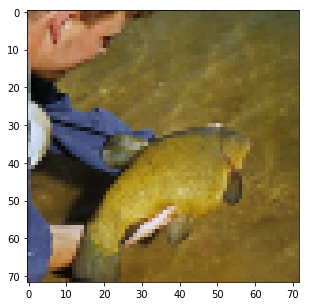

In [23]:
show_img(x,0)

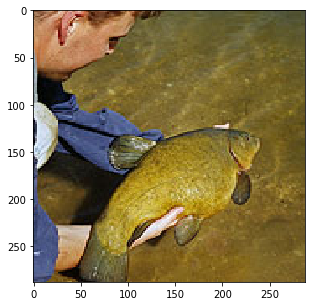

In [24]:
show_img(y,0)

In [128]:
batches = [next(iter(md.aug_dl)) for i in range(9)]

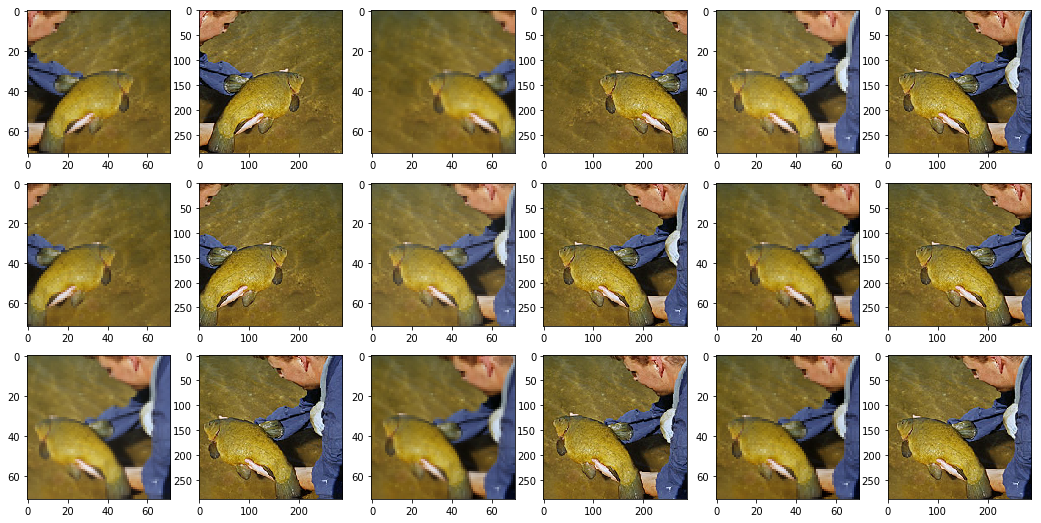

In [129]:
fig, axes = plt.subplots(3, 6, figsize=(18, 9))
for i,(x,y) in enumerate(batches):
    axes.flat[i*2].imshow(denorm(x)[0])
    axes.flat[i*2+1].imshow(denorm(y)[0])

## Model

In [13]:
class BnReluConv(nn.Module):
    def __init__(self, ni, nf, kernel_size=3, bias=False):
        super().__init__()
        self.bn = nn.BatchNorm2d(ni)
        self.conv = nn.Conv2d(ni, nf, kernel_size, padding=kernel_size//2, bias=bias)
    
    def forward(self, x): return self.conv(F.relu(self.bn(x), inplace=True))

class ResBlock(nn.Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.conv1 = BnReluConv(ni, nf)
        self.conv2 = BnReluConv(ni, nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [14]:
class SrResnet(nn.Module):
    def __init__(self, do_sigmoid=False):
        super().__init__()
        self.do_sigmoid = do_sigmoid
        self.conv1 = nn.Conv2d(3, 64, 9, padding=4, bias=False)
        self.blocks = nn.ModuleList([ResBlock(64, 64) for i in range(4)])
        self.uscale = nn.Upsample(scale_factor=2, mode='bilinear')
        self.uconv1 = BnReluConv(64, 64)
        self.uconv2 = BnReluConv(64, 64)
        self.conv2 = BnReluConv(64, 3, kernel_size=9, bias=True)
        
    def forward(self, x):
        x = self.conv1(x)
        for block in self.blocks: x = block(x)
        x = self.uconv1(self.uscale(x))
        x = self.uconv2(self.uscale(x))
        x = self.conv2(x)
        return F.sigmoid(x) if self.do_sigmoid else x

In [15]:
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [16]:
m = SrResnet()
learn = Learner(md, SingleModel(to_gpu(m)), opt_fn=opt_fn)
learn.crit = F.mse_loss

In [118]:
learn.lr_find()
learn.sched.plot()

A Jupyter Widget

 52%|█████▏    | 1132/2187 [02:45<02:34,  6.83it/s, loss=2.04] 

In [16]:
lr=1e-3

In [149]:
learn.fit(lr, 1, cycle_len=10, use_clr=(40,10))

A Jupyter Widget

epoch      trn_loss   val_loss                                 
    0      0.229621   0.188788  
    1      0.223154   0.178119                                 
    2      0.215686   0.163744                                 
    3      0.187137   0.161402                                 
    4      0.208722   0.173219                                 
    5      0.210131   0.165017                                 
    6      0.213894   0.161525                                 
    7      0.210688   0.160905                                 
    8      0.186913   0.162233                                 
    9      0.197294   0.159181                                 



[0.15918082]

In [150]:
preds,y = learn.predict_with_targs()

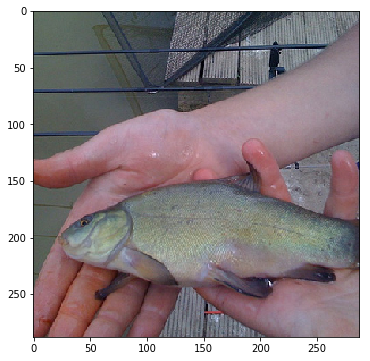

In [166]:
idx=1
show_img(y,idx)

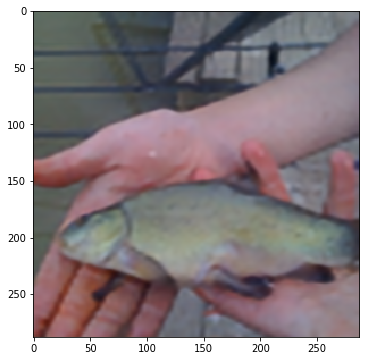

In [167]:
show_img(preds,idx);

## Perceptual loss

In [16]:
m_vgg = vgg16(True).cuda().eval()
set_trainable(m_vgg, False)

In [17]:
# m_vgg = nn.Sequential(*children(m_vgg)[:13]).cuda().eval()

In [18]:
block_ends = [i-1 for i,o in enumerate(children(m_vgg))
              if isinstance(o,nn.MaxPool2d)][1:]
block_ends

[12, 22, 32, 42]

In [19]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()        

In [20]:
class FeatureLoss(nn.Module):
    def __init__(self, m, layer_ids, layer_wgts):
        super().__init__()
        self.m,self.wgts = m,layer_wgts
        self.sfs = [SaveFeatures(m[i]) for i in layer_ids]

    def forward(self, input, target, sum_layers=True):
        res = [F.mse_loss(input, target)/30]
        self.m(VV(target.data))
        targ_feat = [V(o.features.data.clone()) for o in self.sfs]
        self.m(V(input.data))
        res += [F.mse_loss(inp.features,targ)*wgt for inp,targ,wgt in zip(self.sfs, targ_feat, self.wgts)]
        if sum_layers: res = sum(res)
        return res
    
    def close(self):
        for o in self.sfs: o.remove()

In [21]:
layers = block_ends[:2]
wgts = [1,1]

In [28]:
learn.crit.close()

In [22]:
m = SrResnet()
learn = Learner(md, SingleModel(to_gpu(m)), opt_fn=opt_fn)
learn.crit = FeatureLoss(m_vgg, layers, wgts)

A Jupyter Widget

epoch      trn_loss   val_loss                                
    0      0.134463   0.210457  



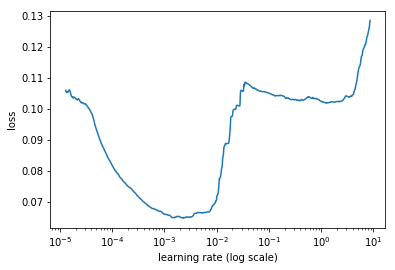

In [24]:
learn.lr_find()
learn.sched.plot()

In [23]:
lr=1e-3

In [24]:
learn.fit(lr, 1, cycle_len=50, use_clr=(40,10))

A Jupyter Widget

epoch      trn_loss   val_loss                                
    0      0.060938   0.060833  
    1      0.058638   0.058059                                
    2      0.056239   0.055563                                
    3      0.054544   0.052967                                
    4      0.053142   0.052408                                
    5      0.052879   0.05113                                 
    6      0.052181   0.051194                                
    7      0.05199    0.049974                                
    8      0.050901   0.050163                                
    9      0.050675   0.051644                                
    10     0.050466   0.04996                                 
    11     0.050503   0.047803                                
    12     0.050279   0.04915                                 
    13     0.050781   0.050121                                
    14     0.050596   0.048796                                
    15     0.050151   

[0.047576282]

In [31]:
learn.save('sr-samp')

In [24]:
learn.load('sr-samp')

In [26]:
x,y=next(iter(md.val_dl))

In [27]:
learn.model.eval()
preds = learn.model(V(x))
learn.crit(preds, V(y), sum_layers=False)

[Variable containing:
 1.00000e-03 *
   3.3008
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
 1.00000e-02 *
   2.5743
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
 1.00000e-02 *
   1.1072
 [torch.cuda.FloatTensor of size 1 (GPU 0)]]

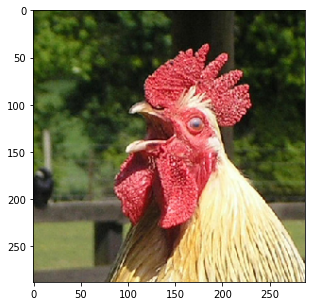

In [45]:
idx=15
show_img(y,idx)

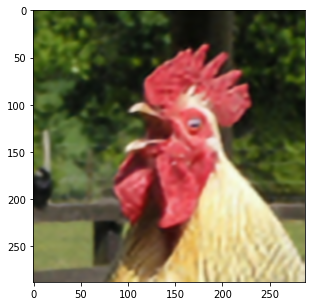

In [46]:
show_img(preds,idx)

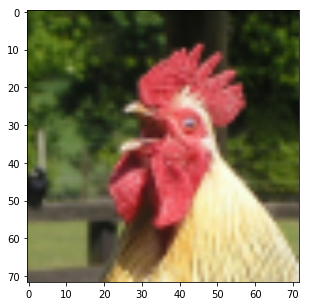

In [47]:
show_img(x,idx)